# Contrastive predictive coding - work in progress

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import soundfile as sf
import torch.optim as optim

## key idea

$X = [x_1, x_2, ..., x_n]$ is a vector of $N$ samples containing $1$ positive sample from $p(x_{t+k}|c_t)$ and $N-1$ negative samples drawn from the distribution $p(x_{t+k})$. These are the other samples in the batch at the same timestep $k$.

Each batch $X$ is of size $N * channel * seq$. We select one random time point between 0 and sequence len to be $t=0$. We use the same t for each sample $n$ in the batch.

Now, for each sample $n$ we need to compute:  
- the past context $c_t$
- the future encoded time steps $z_{t+1},z_{t+2},...,z_{t+k}$  

we will then teach the network to classify for each time step $k$, what is the correct $z_{t+k}$ among the $N$ samples within the batch, given the context $c_t$

$c_t$ for each $n$ is given by first encoding at once the whole batch $X$ until $t=0$, that is  $z_{t-k:t}=g_{enc}(X_{t-k:t})$. This returns a tensor of size $N * channel * seq$.  
Second we reshape $z_{t-k:t}$ to $N * seq * channel$ and pass it to $g_{ar}$, so that $c_t = g_{ar}(z_{t-k:t})$. This returns a tensor of shape $??$ (check what GRU returns)

$f_k(x_{t+k},c_t) = exp(z^T_{t+k} W_k c_t)$

For example, for a batch of N samples at time $t+k$ the correct output of $f_k(x_{t+k},c_t)$ is the identity matrix of size $NxN$.

\begin{bmatrix}
1,0,0,0 \\
0,1,0,0 \\
0,0,1,0 \\
0,0,0,1 
\end{bmatrix}



dataset: LibriSpeech - train-clean-100.tar.gz|

http://www.openslr.org/12/




## CPC architecture

In [12]:
class CPC(nn.Module):

    def __init__(self, n_timesteps, n_samples, seq_len):
        
        super(CPC, self).__init__()
        
        self.n_timesteps = n_timesteps
        self.n_samples = n_samples
        self.seq_len = seq_len
        self.comp_rate = 160

        self.g_enc = nn.Sequential(
            
                        nn.Conv1d(1, 512, stride=5, kernel_size=10, padding=3, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),

                        nn.Conv1d(512, 512, stride=4, kernel_size=8, padding=2, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),

                        nn.Conv1d(512, 512, stride=2, kernel_size=4, padding=1, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),

                        nn.Conv1d(512, 512, stride=2, kernel_size=4, padding=1, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True),

                        nn.Conv1d(512, 512, stride=2, kernel_size=4, padding=1, bias=False),
                        nn.BatchNorm1d(512),
                        nn.ReLU(inplace=True)

                         )

        # autoregressive unit
        self.g_ar = nn.GRU(512, 256, batch_first=True)

        # list of W for each k timestep
        # note the input=256 from the GRU, output=512 to match the size of z
        self.W = nn.ModuleList([nn.Linear(256,512) for t in range(self.n_timesteps)])

        # softmax function to compute the prediction
        self.softmax = nn.Softmax()

        # log softmax function to compute final loss
        self.log_softmax = nn.LogSoftmax()


        def weights_initialization(module):

            if type(module) == nn.Conv1d:
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')

            elif type(module) == nn.BatchNorm1d:
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)

            elif type(module) == nn.Linear:
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')

            elif type(module) == nn.GRU:
                for name, param in module.named_parameters():
                    if 'weight' in name:
                        nn.init.kaiming_normal_(param.data, mode='fan_out', nonlinearity='relu')


        self.apply(weights_initialization)



    # hidden state initialization with zeros for first gru loop
    def initialize_hidden(self): # n_samples should be passed as a parameter, allows more freedom to train with different batch sizes

        return torch.zeros(1, self.n_samples, self.g_ar.hidden_size)    
    
    
    def forward(self, X, hidden):
        
        # n_samples should be passed as a parameter, allows more freedom to train with different batch sizes
        
        z = self.g_enc(X)
        z = z.transpose(1,2)

        t = torch.randint(1, self.seq_len // self.comp_rate - self.n_timesteps, size=(1,))
#         print('random time sample: ',t)
        
        c_t = z[:,:t,:]
        c_t, hidden = self.g_ar(c_t)
        c_t = c_t[:,t-1,:].view(self.n_samples, 256)

        loss = 0
        acc = []

        for k in range(n_timesteps):

            w_k = self.W[k]
            y_k = w_k(c_t)

            z_k = z[:,t+k,:].view(self.n_samples,512)      

            f_k = torch.mm(z_k, y_k.transpose(0,1))
            
            # compute loss
            loss_k = self.log_softmax(f_k)
            loss_k = torch.diagonal(loss_k)
            loss_k = torch.sum(loss_k)

            loss += loss_k
            
            # compute correct output
            pred_k = self.softmax(f_k)
            pred_k = torch.argmax(pred_k, dim=0)
            
            gt_k = torch.arange(0, self.n_samples)
            
            corr_k = torch.eq(pred_k,gt_k)
            corr_k = torch.sum(corr_k)
            acc_k = corr_k.item()/self.n_samples
            
            acc.append(acc_k)
            

        loss *= -1
        loss /= self.n_samples*self.n_timesteps
        

        return loss, acc, hidden
    
    
    def predict(self, X, hidden):
        
        z = self.g_enc(X)
        z = z.transpose(1,2)
        c_t, hidden = self.g_ar(z)
        
        return c_t[:,-1,:], hidden

## Librispeech Dataset

In [13]:
class LibriSpeech100_dataset(Dataset):
    
    def __init__(self, file_list_path, data_path, seq_len):

        self.file_list_path = file_list_path
        self.data_path = data_path
        self.file_list = open(file_list_path).read().split('\n')
        self.seq_len = seq_len

        self.audio_files = []
        
        ## consider using a preprocessed data struct to avoid overloading memory
        
        for filename in self.file_list[:400]:
            reader_id, chapter_id, _ = filename.split('-') 
            path = self.data_path.format(reader_id,chapter_id,filename)
            audio_file, sr = sf.read(path)
            if audio_file.shape[0]>self.seq_len:
                self.audio_files.append(audio_file)
    
    
    def __len__(self):
        return len(self.audio_files)
    
    def __getitem__(self, idx):
        
        ## consider using a preprocessed data struct to avoid overloading memory
        audio_file = self.audio_files[idx]
        rnd_idx = np.random.randint(0, len(audio_file)-self.seq_len)
        audio_sample = audio_file[rnd_idx:rnd_idx+self.seq_len]
        audio_sample = audio_sample.reshape(1,-1)
        
        return audio_sample

## train and validation functions

In [14]:
def train(model, optimizer, train_dataloader):

    model.train()
    total_train_loss = 0
    total_train_acc = []

    for idx_batch, batch in enumerate(train_dataloader):

        optimizer.zero_grad()

        hidden = model.initialize_hidden()
        loss, acc, hidden = model.forward(batch.float(),hidden)

        loss.backward()
        optimizer.step()
        
        total_train_loss += len(batch) * loss
        total_train_acc.append(acc)

    total_train_loss /= len(train_dataloader.dataset)

    return total_train_loss, total_train_acc


def validation(model, valid_dataloader):

    model.eval()
    total_val_loss = 0
    total_val_acc = []


    with torch.no_grad():
        for idx_batch, batch in enumerate(valid_dataloader):
    #             print(batch.size())
            hidden = model.initialize_hidden()
            val_loss, val_acc, hidden = model.forward(batch.float(), hidden)
            total_val_loss += len(batch) * val_loss
            total_val_acc.append(val_acc)


    total_val_loss /= len(valid_dataloader.dataset)
    
    return total_val_loss, total_val_acc

## model and dataset initialization

In [15]:
seq_len = 20480
comp_rate = 160
n_timesteps = 12
n_samples = 8

In [16]:
train_list_path = '/Users/yc00088/Documents/Affective_computing/projects/contrastive_predictive_coding/data/LibriSpeech100_labels_split/train_split.txt'
file_path = '/Users/yc00088/Documents/Affective_computing/datasets/libri_speech/LibriSpeech/train-clean-100/{0}/{1}/{2}.flac'

libri_train = LibriSpeech100_dataset(train_list_path,file_path,seq_len)

In [17]:
valid_list_path = '/Users/yc00088/Documents/Affective_computing/projects/contrastive_predictive_coding/data/LibriSpeech100_labels_split/test_split.txt'
file_path = '/Users/yc00088/Documents/Affective_computing/datasets/libri_speech/LibriSpeech/train-clean-100/{0}/{1}/{2}.flac'

libri_valid = LibriSpeech100_dataset(valid_list_path,file_path,seq_len)

In [18]:
train_dataloader = DataLoader(libri_train, batch_size=n_samples, shuffle=True, num_workers=0)
valid_dataloader = DataLoader(libri_valid, batch_size=n_samples, shuffle=True, num_workers=0)

In [19]:
cpc_test = CPC(n_timesteps, n_samples, seq_len)

In [20]:
train_params = [p for p in cpc_test.parameters() if p.requires_grad == True]
optimizer = optim.Adam(train_params)

## training

/anaconda3/envs/nlp_env/lib/python3.6/site-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/anaconda3/envs/nlp_env/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


-- epoch 0 --
train loss: 4.0248026847839355
valid loss: 2.0811803340911865


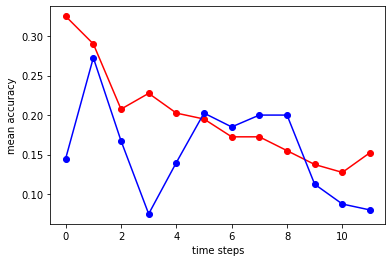

/anaconda3/envs/nlp_env/lib/python3.6/site-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/anaconda3/envs/nlp_env/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


-- epoch 1 --
train loss: 2.7589874267578125
valid loss: 2.278536796569824


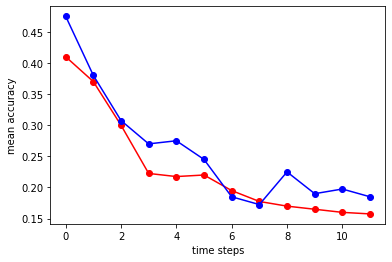

/anaconda3/envs/nlp_env/lib/python3.6/site-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/anaconda3/envs/nlp_env/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


-- epoch 2 --
train loss: 2.024038314819336
valid loss: 2.5262978076934814


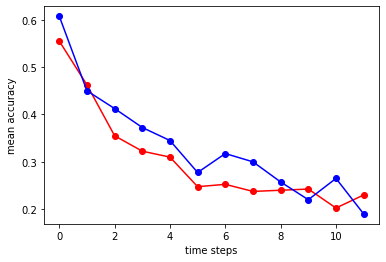

/anaconda3/envs/nlp_env/lib/python3.6/site-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/anaconda3/envs/nlp_env/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


-- epoch 3 --
train loss: 1.9072996377944946
valid loss: 1.9605103731155396


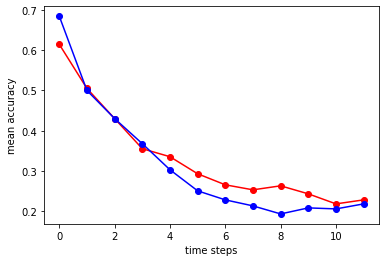

/anaconda3/envs/nlp_env/lib/python3.6/site-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/anaconda3/envs/nlp_env/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


-- epoch 4 --
train loss: 1.99385666847229
valid loss: 2.573119878768921


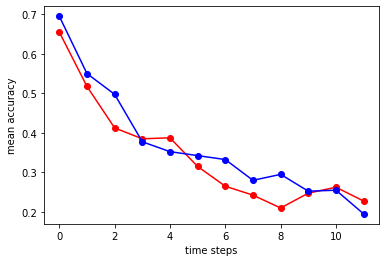

/anaconda3/envs/nlp_env/lib/python3.6/site-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/anaconda3/envs/nlp_env/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


-- epoch 5 --
train loss: 2.1314799785614014
valid loss: 1.9957047700881958


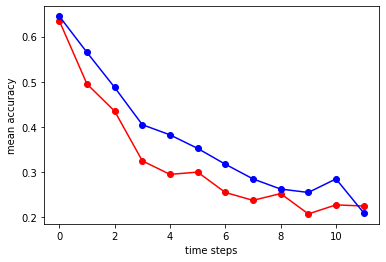

/anaconda3/envs/nlp_env/lib/python3.6/site-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/anaconda3/envs/nlp_env/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


-- epoch 6 --
train loss: 2.0263843536376953
valid loss: 2.582470417022705


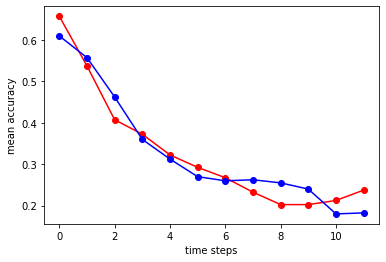

/anaconda3/envs/nlp_env/lib/python3.6/site-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/anaconda3/envs/nlp_env/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


-- epoch 7 --
train loss: 1.8132394552230835
valid loss: 1.8838948011398315


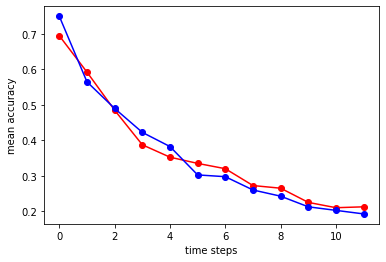

/anaconda3/envs/nlp_env/lib/python3.6/site-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/anaconda3/envs/nlp_env/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


-- epoch 8 --
train loss: 1.7469314336776733
valid loss: 1.7908813953399658


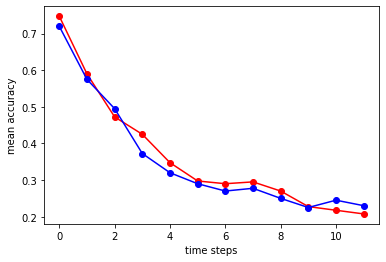

/anaconda3/envs/nlp_env/lib/python3.6/site-packages/ipykernel_launcher.py:105: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/anaconda3/envs/nlp_env/lib/python3.6/site-packages/ipykernel_launcher.py:112: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


-- epoch 9 --
train loss: 1.6844919919967651
valid loss: 1.7776176929473877


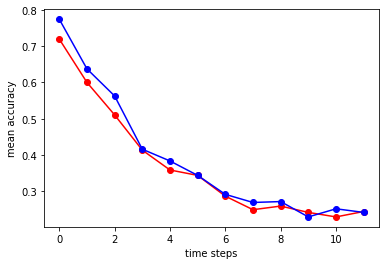

In [21]:
for epoch in range(10):

    total_train_loss, total_train_acc = train(cpc_test, optimizer, train_dataloader)
    total_valid_loss, total_valid_acc = validation(cpc_test, valid_dataloader)
    
    print('-- epoch {0} --'.format(epoch))
    print('train loss: {0}'.format(total_train_loss))
    print('valid loss: {0}'.format(total_valid_loss))
    
    
    plt.plot(np.mean(total_train_acc,0),'r-o')
    plt.ylabel('mean accuracy')
    plt.xlabel('time steps')

    plt.plot(np.mean(total_valid_acc,0),'b-o')
    plt.ylabel('mean accuracy')
    plt.xlabel('time steps')
    
    plt.show()